In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from tools import pickle_dump, pickle_in

from lm import live_data

In [39]:
# Load test samples
samples_g_1, samples_c_1, samples_w_1 = pickle_in("test_samples/samples_1.pickle")
samples_g_2, samples_c_2, samples_w_2 = pickle_in("test_samples/samples_low_var.pickle")
samples_g_3, samples_c_3, samples_w_3 = pickle_in("test_samples/samples_high_dim.pickle")

In [27]:
def sigma_squared(d, X_i, logL_i):
    """Sigma squared as a function of d and the datapoints"""
    n = len(X_i)
    logsum = np.sum(logL_i)
    sum_X_4d = np.sum(X_i**(4/d))
    sum_X_2d = np.sum(X_i**(2/d))
    sum_log_X_2d = np.sum(X_i**(2/d) * logL_i)
    numerator = n * sum_X_4d - sum_X_2d**2
    denominator = 2 * logsum * sum_X_2d - 2*n*sum_log_X_2d
    return numerator/denominator

def logLmax(d, X_i, logL_i):
    n = len(X_i)
    logsum = np.sum(logL_i)
    sum_X_2d = np.sum(X_i**(2/d))
    return 1/n * logsum + 1/(2*n*sigma_squared(d, X_i, logL_i)) * sum_X_2d

In [ ]:
def logL_model(theta, X):
    """
    Input: (theta, X)
    Output: (logLmax - X**(2/d)/(2*sigma**2))
    """
    logLmax, d, sigma = theta
    return logLmax - X**(2/d)/(2*sigma**2)

In [3]:
from scipy.optimize import least_squares
def analytic_lm(logLdata, Xdata, d0, bounds=(0.99, np.inf)):
    """
    Input: logLdata, Xdata, theta0
    Output: (solution), solution of parameters to least squares fit of logLdata vs Xdata using
            Levenberg-Marquardt, implemented by scipy.optimize.least_squares
    """
    def sigma_squared(d, X_i, logL_i):
        """Sigma squared as a function of d and the datapoints"""
        n = len(X_i)
        logsum = np.sum(logL_i)
        sum_X_4d = np.sum(X_i**(4/d))
        sum_X_2d = np.sum(X_i**(2/d))
        sum_log_X_2d = np.sum(X_i**(2/d) * logL_i)
        numerator = n * sum_X_4d - sum_X_2d**2
        denominator = 2 * logsum * sum_X_2d - 2*n*sum_log_X_2d
        return numerator/denominator

    def logLmax(d, X_i, logL_i):
        n = len(X_i)
        logsum = np.sum(logL_i)
        sum_X_2d = np.sum(X_i**(2/d))
        return 1/n * logsum + 1/(2*n*sigma_squared(d, X_i, logL_i)) * sum_X_2d

    def logL_loss(d):
        return logLdata - (logLmax(d, Xdata, logLdata) - (Xdata**(2/d)) / (2 * sigma_squared(d, Xdata, logLdata)) )
    solution = least_squares(logL_loss, d0, bounds=bounds)
    
    return solution

In [33]:
def local_analytic_lm(samples, iteration, d0=None):
    live_logL, live_X = live_data(samples, iteration)
    d = d0 if d0 else 1
    solution = analytic_lm(live_logL, live_X, d)
    return solution

In [34]:
from plots import uniform_iterations_array
def get_params(samples, iteration, d):
    logLdata, Xdata = live_data(samples, iteration)
    sigma = np.sqrt(sigma_squared(d, Xdata, logLdata))
    logL_max = logLmax(d, Xdata, logLdata)
    return logL_max, sigma

def estimate_iterations_analytic(samples, iterations):
    logLmax_estimates = []
    d_estimates = []
    sigma_estimates = []
    for i, iteration in enumerate(iterations):
        d = local_analytic_lm(samples, iteration).x
        logL_max, sigma = get_params(samples, iteration, d)
        logLmax_estimates.append(logLmax)
        d_estimates.append(d)
        sigma_estimates.append(sigma)
        print(f"Iteration {i+1} complete ({iteration})")
    return logLmax_estimates, d_estimates, sigma_estimates

Iteration 1 complete (12849)
Iteration 2 complete (25699)
Iteration 3 complete (38549)
Iteration 4 complete (51399)
Iteration 5 complete (64249)
Iteration 6 complete (77098)
Iteration 7 complete (89948)
Iteration 8 complete (102798)
Iteration 9 complete (115648)
Iteration 10 complete (128498)


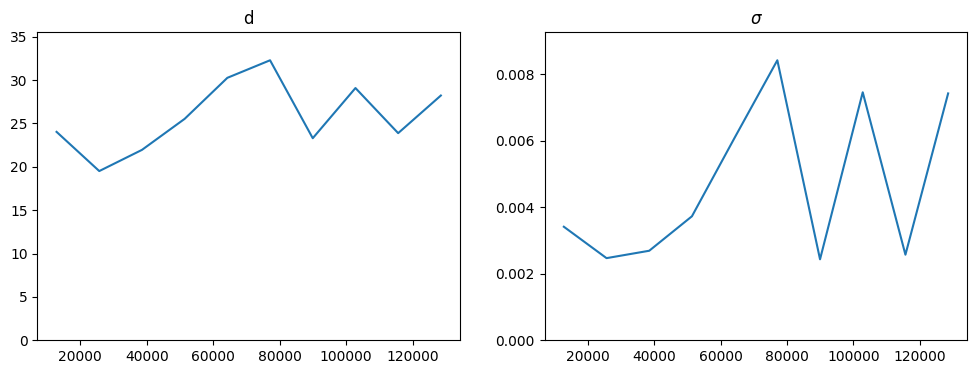

In [42]:
from plots import plot_estimates
iterations = uniform_iterations_array(samples_c_3, 10)
estimates = estimate_iterations_analytic(samples_c_3, iterations)
plot_estimates(iterations, estimates[1], estimates[2])

12849
0 [0.5, 1.0, 1e-05] [-6.91973146e+03  1.48829532e+00  2.49368895e-08] 49035882.899464995
1 [0.5, 27.999999999999996, 0.09999999999999992] [-6.90721061e+03  1.50327944e+00  2.14379552e-08] 45070054.22097961
Iteration 12849 complete
25699
0 [0.5, 1.0, 1e-05] [-1.65587172e+03  1.00000000e+00  1.00000000e-05] 4355268.142077942
1 [0.5, 27.999999999999996, 0.09999999999999992] [-1.65032494e+03  2.62003192e+00  2.57566956e-08] 3540772.5305967806
Iteration 25699 complete
38549
0 [0.5, 1.0, 1e-05] [-3.93932346e+02  1.00000000e+00  1.00000000e-05] 333516.02715854405
1 [0.5, 27.999999999999996, 0.09999999999999992] [-3.82899843e+02  3.70047090e+00  2.71891989e-08] 221911.94893564263
Iteration 38549 complete
51399
0 [0.5, 1.0, 1e-05] [-9.50695235e+01  1.00000000e+00  1.00000000e-05] 24792.646315284543
1 [0.5, 27.999999999999996, 0.09999999999999992] [-8.52610261e+01  4.81856605e+00  3.22270956e-08] 8228.954505132277
Iteration 51399 complete
64249
0 [0.5, 1.0, 1e-05] [-2.36258619e+01  1.00000

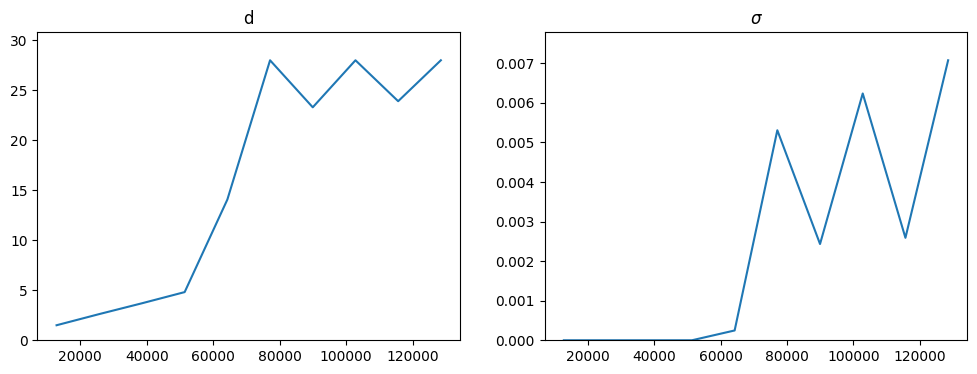

In [46]:
from lm import estimate_iterations, log_uniform_guesses, global_live_lm
estimates = estimate_iterations(samples_c_3, global_live_lm, iterations, (log_uniform_guesses, 2))
plot_estimates(iterations, estimates[1], estimates[2])

Iteration 1/20 complete (1021)
Iteration 2/20 complete (2042)
Iteration 3/20 complete (3063)
Iteration 4/20 complete (4084)
Iteration 5/20 complete (5105)
Iteration 6/20 complete (6126)
Iteration 7/20 complete (7147)
Iteration 8/20 complete (8168)
Iteration 9/20 complete (9189)
Iteration 10/20 complete (10210)
Iteration 11/20 complete (11231)
Iteration 12/20 complete (12252)
Iteration 13/20 complete (13273)
Iteration 14/20 complete (14294)
Iteration 15/20 complete (15315)
Iteration 16/20 complete (16336)
Iteration 17/20 complete (17357)
Iteration 18/20 complete (18378)
Iteration 19/20 complete (19399)
Iteration 20/20 complete (20420)


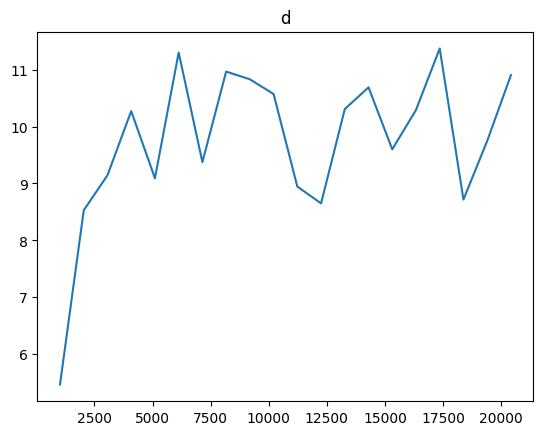

In [21]:
# iterations = uniform_iterations_array(samples_g_1, 10)
# estimate_iterations_analytic()
plot_d_analytic(samples_c_1, 20)

In [5]:
d = 10
logL, X = live_data(samples_c_1, 4000)
analytic_lm(logL, X, 2).x

/home/zixiao/Documents/III/aeons/venv/lib/python3.10/site-packages/anesthetic-2.0.0b12-py3.10.egg/anesthetic/labelled_pandas.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


array([10.36128789])

In [6]:
from lm import estimate_iterations
from plots import plot_statistics_sample
plot_statistics_sample(samples_g_1, local_analytic_lm, 10, [5])

Iteration 2025 complete
Iteration 4050 complete
Iteration 6075 complete
Iteration 8101 complete
Iteration 10126 complete
Iteration 12151 complete
Iteration 14176 complete
Iteration 16202 complete
Iteration 18227 complete
Iteration 20252 complete


ValueError: too many values to unpack (expected 3)